In [1]:
### imports
#import arcpy
import matplotlib.pyplot as plt

%matplotlib inline

import glob
import numpy as np
import pandas as pd

print("Imports complete.")

Imports complete.


In [2]:
### setup

# DEM to extract profiles from
dem = "C:/Git_repos/channel_fitting/test_dem.tif" 

# a shapefile containing profileson the DEM
profile_file = "C:/Git_repos/channel_fitting/test_profile.shp" 

# if the profile file has multiple profiles, they get split and put in this folder
output_shapefile_folder = "C:/Git_repos/channel_fitting/shapefiles/"

# each profile will generate a X, Y table in this location
output_table_folder = "C:/Git_repos/channel_fitting/tables/"

# the name and location where the final data will be saved
output_textfile = "C:/Git_repos/channel_fitting/polyfit_values.csv"

print("Variables set.")

Variables set.


In [ ]:
### split file into individual lines

# convert to search cursor
with arcpy.da.SearchCursor(profile_file, "FID") as cursor:
    
    # loop through cursor
    for row in cursor:
        
        # select each row
        sql="""{} = {}""".format(arcpy.AddFieldDelimiters(profile_file, arcpy.Describe(profile_file).OIDFieldName), row[0])
        
        # copy each row to a new file
        arcpy.Select_analysis(in_features=profile_file, 
                              out_feature_class=os.path.join(output_shapefile_folder,'Shapefile_{}.shp'.format(row[0])), 
                              where_clause=sql)

print("Individual profiles generated.")

In [ ]:
### run the stack profile

# get a list of shapefiles to process
shapefile_list = glob.glob(output_shapefile_folder + "*.shp")

# loop through each shapefile
for shapefile in shapefile_list:
    
    # get name
    out_name = arcpy.Describe(shapefile).basename
    
    # run the stack profile
    arcpy.StackProfile_3d(shapefile, profile_targets=[dem], out_table=output_table_folder + out_name  + ".csv")
    
print("Profile tables generated.")

In [5]:
### process the tables
    
# write the header -- WILL OVERWRITE
with open(output_textfile, "w") as output:
    output.write("table, a, b, c \n")

    
# get a list of all the tables to process
table_list = glob.glob(output_table_folder + "*.csv")

# loop through all the tables
for profile_table in table_list:
    
    # open the table
    table = pd.read_csv(profile_table)
    
    # get x and y
    x_values = table["FIRST_DIST"].tolist() 
    y_values = table["FIRST_Z"].tolist()
    
    second_order_poly_fit = np.polyfit(x_values, y_values, 2)

    # write the table values
    with open(output_textfile, "a") as output:
        output.write("{}, {}, {}, {}\n".format(profile_table, 
                                               second_order_poly_fit[0], 
                                               second_order_poly_fit[1], 
                                               second_order_poly_fit[2]))
        
    print("{}\nFit: {}x^2 + {}x + {}".format(profile_table,
                                         round(second_order_poly_fit[0],4),
                                         round(second_order_poly_fit[1],4),
                                         round(second_order_poly_fit[2],4)))

Fit: 0.0006x^2 + -0.2528x + 545.0235


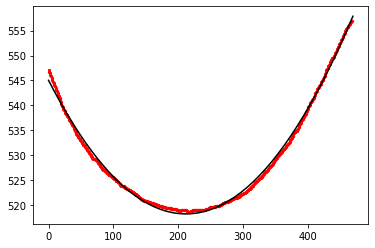

In [6]:
### plotting
# plot original values
plt.scatter(x_values, y_values, c="r", s= 5)

# plot fit
x_dummy = np.linspace(0, len(x_values))
plt.plot(x_dummy, second_order_poly_fit[0]*x_dummy**2 + second_order_poly_fit[1]*x_dummy + second_order_poly_fit[2], c="k")
plt.show()